# Try Finetuned YOLO, ONNX Inference

Try inferencing with a finetuned YOLO checkpoint, using the ONNX runtime to serve the model

In [1]:
%pip install -q opencv-python onnx onnxruntime torch requests
%pip list | awk '/opencv|onnx|onnxruntime|torch|requests/ {print $1}'


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
onnx
onnxconverter-common
onnxruntime
opencv-python
requests
requests-oauthlib
requests-toolbelt
skl2onnx
torch
torchvision
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libs
import os
from pathlib import PosixPath
import onnxruntime as rt
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
# declare global setting variables
HOME_DIR: str = os.getenv("HOME")
PRJ_PATH: str = f"{HOME_DIR}/camera-detection"
DRONE_TEST_IMG: str = "drone_test.jpg"
AIRCRAFT_TEST_IMG: str = "aircraft_test.jpg"
LABEL_FILE: str = "labels.yaml"

# search onnx checkpoint
onnx_ckpt = max(PosixPath(PRJ_PATH).rglob("*.onnx"), key=os.path.getmtime)
print(f"Using YOLO Model Original Checkpoint at: ONNX - {onnx_ckpt}")

# load labels
import yaml
with open(LABEL_FILE, "r") as f:
    labels = yaml.safe_load(f).get("names")

Using YOLO Model Original Checkpoint at: ONNX - /opt/app-root/src/camera-detection/jupyter/runs/detect/train/weights/best.onnx


## First thing, let's try inference locally by loading the ONNX checkpoint directly.

This will make sure the model works as expected in a controlled environment (e.g. a jupyter notebook)

In [4]:
# load checkpoint from disk
onnx_model = rt.InferenceSession(onnx_ckpt, providers=rt.get_available_providers())

# get inputs and outputs of the onnx model
onnx_input = onnx_model.get_inputs()[0]
onnx_output = onnx_model.get_outputs()[0]
input_name = onnx_input.name
output_name = onnx_output.name

print(f"ONNX Model:\n Input: {input_name}, shape: {onnx_input.shape}\n Output: {output_name}, shape: {onnx_output.shape}")

ONNX Model:
 Input: images, shape: [1, 3, 640, 640]
 Output: output0, shape: [1, 5, 8400]


In [5]:
# datapoint visualization
def plot(img_rgb: torch.Tensor, inferenceOutput, confidences, classes, labels) -> None:
    """
        plot an image with its relative object bounding boxes in overlay
    """
    # permute channels and get image sizes
    img = img_rgb.permute(2, 1, 0)
    img_h, img_w, channels = img.shape

    # plot image
    plt.title(f"Dataset Point: {len(inferenceOutput)} objects")
    plt.imshow(img_rgb)

    # calculate bounding boxes
    axes = plt.gca()
    for i,o in enumerate(inferenceOutput):
        c = confidences[i]
        cl = classes[i]

        x1, y1, x2, y2 = o
        #label = object_classes[int(obj.cls)]
        print(f"Bounding Box: {x1}, {y1}, {x2}, {y2}")

        # add bounding box
        from matplotlib.patches import Rectangle
        axes.add_patch(Rectangle((x1,y1), x2,y2, color="white", fill=None))
        # add label
        ltext = f"{c} - {labels.get(cl)}"
        lpos = (x1, y1 - 10)
        axes.text(lpos[0], lpos[1], ltext, color="white", fontsize=12)

    # show datapoint
    plt.show()

In [6]:
# load test image from filesystem
test_img = cv2.imread(DRONE_TEST_IMG)
print(f"Loaded image {DRONE_TEST_IMG} to memory. Image Size: {test_img.size}@({test_img.shape})")

# resize if necessary
onnx_input_img = test_img.copy()
N, C, W, H = onnx_input.shape
iH, iW, iC = test_img.shape
if (H != iH) or (W != iW):
    print(f"Resizing image to {W}x{H} - Current size is {iW}x{iH}")
    resized_img = cv2.resize(onnx_input_img, (W, H))
else:
    resized_img = onnx_input_img

# run inference
resized_img = np.transpose(resized_img, (2, 0, 1)).astype(np.float32) / 255.0
resized_img = np.expand_dims(resized_img, axis=0)
onnx_output = onnx_model.run(None, {input_name: resized_img})

Loaded image drone_test.jpg to memory. Image Size: 1309770@((539, 810, 3))
Resizing image to 640x640 - Current size is 810x539


In [7]:
# display results
CONF_THRESHOLD = 0.55
predictions = onnx_output[0][0]
boxes_data = predictions[0:4, :]
scores_data = predictions[4:, :]

boxes, confidences, class_ids = [], [], []

for i in range(predictions.shape[1]):
    class_scores = 1 / (1 + np.exp(-scores_data[:, i]))
    max_score = np.max(class_scores)
    class_id = np.argmax(class_scores)
    cx, cy, w_box, h_box = boxes_data[:, i]

    if max_score > CONF_THRESHOLD:
        left = int((cx - w_box / 2) * iW / W)
        top = int((cy - h_box / 2) * iH / H)
        w_px = int(w_box * iW / W)
        h_px = int(h_box * iH / H)

        boxes.append([left, top, w_px, h_px])
        confidences.append(float(max_score))
        class_ids.append(class_id)

[[444, 328, 184, 87], [359, 89, 373, 144], [356, 89, 375, 143], [358, 86, 376, 153], [357, 87, 374, 151], [358, 88, 371, 150]] [0.5502339601516724, 0.5585069060325623, 0.5559228658676147, 0.5683904886245728, 0.5619354248046875, 0.5518211126327515] [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Bounding Box: 444, 328, 184, 87
Bounding Box: 359, 89, 373, 144
Bounding Box: 356, 89, 375, 143
Bounding Box: 358, 86, 376, 153
Bounding Box: 357, 87, 374, 151
Bounding Box: 358, 88, 371, 150


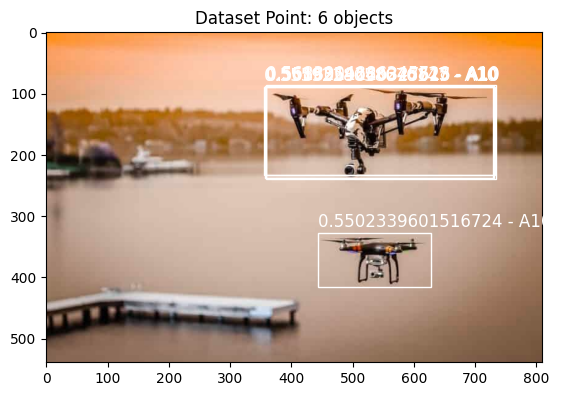

In [8]:
print(boxes, confidences, class_ids)
plot(torch.from_numpy(test_img), boxes, confidences, class_ids, labels)

## Now let's call the remote inference service

In [12]:
# endpoint
DEPLOYED_MODEL: str = "yolo-military-finetuned-3"
INFERENCE_SERVICE_ENDPOINT: str = "https://yolo-military-finetuned-3-ai-dev-demo.apps.cluster-m9k8t.m9k8t.sandbox2813.opentlc.com"
INFER_URL: str = f"{INFERENCE_SERVICE_ENDPOINT}/v2/models/{DEPLOYED_MODEL}/infer"
INPUT_SHAPE: list = [1,3,640,640]
OUTPUT_SHAPE: list = [1,47,8400]

# make request
def rest_request(infer_url, data):
    try:
        import requests
    except Exception as e:
        raise e

    json_data = {
        "inputs": [
            {
                "name": "images",
                "shape": INPUT_SHAPE,
                "datatype": "FP32",
                "data": data,
            }
        ]
    }

    response = requests.post(infer_url, json=json_data, verify=True)
    return response

In [13]:
# call the service
# load test image from filesystem
test_img = cv2.imread(AIRCRAFT_TEST_IMG)
print(f"Loaded image {AIRCRAFT_TEST_IMG} to memory. Image Size: {test_img.size}@({test_img.shape})")

# resize if necessary
onnx_input_img = test_img.copy()
N, C, W, H = onnx_input.shape
iH, iW, iC = test_img.shape
if (H != iH) or (W != iW):
    print(f"Resizing image to {W}x{H} - Current size is {iW}x{iH}")
    resized_img = cv2.resize(onnx_input_img, (W, H))
else:
    resized_img = onnx_input_img

# run inference
resized_img = np.transpose(resized_img, (2, 0, 1)).astype(np.float32) / 255.0
resized_img = np.expand_dims(resized_img, axis=0)

result = rest_request(INFER_URL, resized_img.tolist())
prediction = result.json()

Loaded image aircraft_test.jpg to memory. Image Size: 1279200@((533, 800, 3))
Resizing image to 640x640 - Current size is 800x533


In [14]:
# examine prediction result
if len(prediction.get("outputs")) > 0:
    output_data = prediction.get("outputs")[0]
    data = output_data.get("data")
    print(f"Got {len(data)} bytes in the prediction, type {type(data)}")
    # reshape output
    pred_classes = np.reshape(data, OUTPUT_SHAPE)
    print(f"Reshaped prediction to {pred_classes.shape}")
else:
    print("No Prediction")

Got 394800 bytes in the prediction, type <class 'list'>
Reshaped prediction to (1, 47, 8400)


In [17]:
# display results
CONF_THRESHOLD = 0.55
predictions = pred_classes[0]
print(predictions.shape)
boxes_data = predictions[0:4, :]
scores_data = predictions[4:, :]

boxes, confidences, class_ids = [], [], []

for i in range(predictions.shape[1]):
    class_scores = 1 / (1 + np.exp(-scores_data[:, i]))
    max_score = np.max(class_scores)
    class_id = np.argmax(class_scores)
    cx, cy, w_box, h_box = boxes_data[:, i]

    if max_score > CONF_THRESHOLD:
        left = int((cx - w_box / 2) * iW / W)
        top = int((cy - h_box / 2) * iH / H)
        w_px = int(w_box * iW / W)
        h_px = int(h_box * iH / H)

        boxes.append([left, top, w_px, h_px])
        confidences.append(float(max_score))
        class_ids.append(class_id)

(47, 8400)


[[55, 144, 664, 276], [54, 144, 663, 276], [54, 144, 665, 278], [54, 143, 664, 277], [53, 143, 665, 278], [53, 142, 665, 279]] [0.5984507748598202, 0.6040524372202211, 0.5500336663502136, 0.5952677602447743, 0.6053546428032088, 0.571262496060393] [np.int64(37), np.int64(37), np.int64(37), np.int64(37), np.int64(37), np.int64(37)]
Bounding Box: 55, 144, 664, 276
Bounding Box: 54, 144, 663, 276
Bounding Box: 54, 144, 665, 278
Bounding Box: 54, 143, 664, 277
Bounding Box: 53, 143, 665, 278
Bounding Box: 53, 142, 665, 279


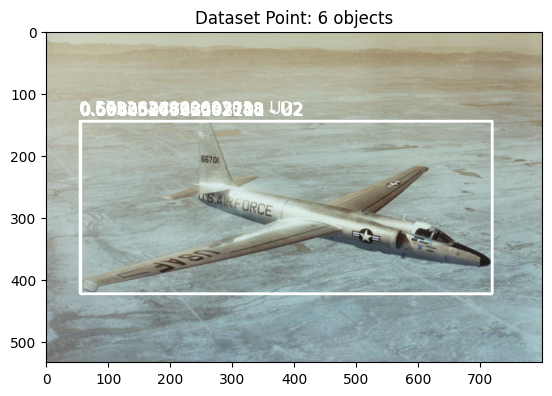

In [18]:
# display prediction
print(boxes, confidences, class_ids)
plot(torch.from_numpy(test_img), boxes, confidences, class_ids, labels)